# VGGT Model

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change location to vggt folder
%cd "/content/drive/MyDrive/vggt/"

/content/drive/MyDrive/vggt


In [3]:
!pip install rasterio

In [4]:
# Import libraries
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import rasterio
from torch.utils.data import Dataset, DataLoader
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn_tif_norm import load_and_preprocess_geotiff

## Env set up

## Training Data

In [5]:
train_input_path = "/content/drive/MyDrive/vggt/input_data/train_input_01"
train_reference_path = "/content/drive/MyDrive/vggt/input_data/train_reference_01"

test_input_path = "/content/drive/MyDrive/vggt/input_data/test_input_01"
test_reference_path = "/content/drive/MyDrive/vggt/input_data/test_reference_01"

In [6]:
# Check files sizes and number of bands
def get_tiff_info(folder_path):
    """
    Reads all GeoTIFF files in a folder and returns their names, dimensions,
    and number of bands.

    Args:
        folder_path (str): The path to the folder containing GeoTIFF files.

    Returns:
        list: A list of tuples, where each tuple contains the filename,
              its dimensions (height, width), and the number of bands.
    """
    tiff_info = []
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return tiff_info

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(".tif"):
            file_path = os.path.join(folder_path, file_name)
            try:
                with rasterio.open(file_path) as src:
                    tiff_info.append((file_name, (src.height, src.width), src.count))
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    return tiff_info

# Use the defined paths (assuming train_input_path, etc. are already defined)
train_input_info = get_tiff_info(train_input_path)
train_reference_info = get_tiff_info(train_reference_path)
test_input_info = get_tiff_info(test_input_path)
test_reference_info = get_tiff_info(test_reference_path)

print("Train Input TIFFs:")
for name, dims, bands in train_input_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTrain Reference TIFFs:")
for name, dims, bands in train_reference_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTest Input TIFFs:")
for name, dims, bands in test_input_info:
    print(f"- {name}: {dims} (Bands: {bands})")

print("\nTest Reference TIFFs:")
for name, dims, bands in test_reference_info:
    print(f"- {name}: {dims} (Bands: {bands})")

Train Input TIFFs:
- tile_1036_518.tif: (518, 518) (Bands: 3)

Train Reference TIFFs:
- tile_1036_518.tif: (518, 518) (Bands: 1)

Test Input TIFFs:
- tile_518_518.tif: (518, 518) (Bands: 3)

Test Reference TIFFs:
- tile_518_518.tif: (518, 518) (Bands: 1)


### Visualize training and test data

In [7]:
# # Visualize training input images
# print("\nVisualizing Training Input Images (First 10):") # Updated print message

# if not os.path.exists(train_input_path):
#     print(f"Folder not found: {train_input_path}")
# else:
#     image_count = 0 # Initialize a counter for images visualized
#     for file_name in os.listdir(train_input_path):
#         if file_name.lower().endswith(".tif"):
#             if image_count >= 10: # Check if we have already visualized 10 images
#                 print("Displayed 10 images. Stopping visualization.")
#                 break # Exit the loop if 10 images are shown

#             file_path = os.path.join(train_input_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Input: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Input: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     elif src.count == 4:
#                         # Four-band image - assuming first 3 are RGB, display as RGB composite
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         # Select only the first 3 bands (index 0, 1, 2)
#                         rgb_composite = image_data[:3, :, :].transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_composite)
#                         plt.title(f"Input: {file_name} (RGB Composite)") # Updated title
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")
#                         # Do not increment image_count as we are skipping visualization

#                 # Increment the counter only if an image was successfully processed for visualization
#                 if src.count in [1, 3, 4]:
#                      image_count += 1

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [8]:
# # Visualize training reference images
# print("\nVisualizing Training Reference Images:")

# if not os.path.exists(train_reference_path):
#     print(f"Folder not found: {train_reference_path}")
# else:
#     image_count = 0  # Initialize a counter for images visualized
#     for file_name in os.listdir(train_reference_path):
#         if file_name.lower().endswith(".tif"):
#             if image_count >= 10: # Check if we have already visualized 10 images
#                 print("Displayed 10 images. Stopping visualization.")
#                 break # Exit the loop if 10 images are shown

#             file_path = os.path.join(train_reference_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale, depth)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Reference: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                         image_count += 1 # Increment counter for successful visualization
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Reference: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                         image_count += 1 # Increment counter for successful visualization
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")
#                         # Do not increment image_count as we are skipping visualization

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [9]:
# # Visualize testing input images
# print("\nVisualizing Testing Input Images:")

# if not os.path.exists(train_input_path):
#     print(f"Folder not found: {test_input_path}")
# else:
#     for file_name in os.listdir(test_input_path):
#         if file_name.lower().endswith(".tif"):
#             file_path = os.path.join(test_input_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Input: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Input: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     elif src.count == 4:
#                         # Four-band image - assuming first 3 are RGB, display as RGB composite
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         # Select only the first 3 bands (index 0, 1, 2)
#                         rgb_composite = image_data[:3, :, :].transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_composite)
#                         plt.title(f"Input: {file_name} (RGB Composite)") # Updated title
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

In [10]:
# # Visualize testing reference images
# print("\nVisualizing Training Reference Images:")

# if not os.path.exists(test_reference_path):
#     print(f"Folder not found: {test_reference_path}")
# else:
#     for file_name in os.listdir(test_reference_path):
#         if file_name.lower().endswith(".tif"):
#             file_path = os.path.join(test_reference_path, file_name)
#             try:
#                 with rasterio.open(file_path) as src:
#                     # Read the raster data
#                     image_data = src.read()

#                     # Determine how to visualize based on the number of bands
#                     if src.count == 1:
#                         # Single-band image (e.g., grayscale, depth)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(image_data[0], cmap='gray') # Use first band, grayscale colormap
#                         plt.title(f"Reference: {file_name}")
#                         plt.colorbar(label='Pixel Value')
#                         plt.show()
#                     elif src.count == 3:
#                         # Three-band image (e.g., RGB)
#                         # Rasterio reads bands in order, often 1, 2, 3 (e.g., Red, Green, Blue)
#                         # For Matplotlib, we need to reorder to RGB if necessary (band order is 0, 1, 2 in arrays)
#                         # Assuming bands are in typical order (Band 1 = Red, Band 2 = Green, Band 3 = Blue)
#                         # image_data shape is (bands, height, width). Transpose to (height, width, bands)
#                         rgb_image = image_data.transpose(1, 2, 0)
#                         plt.figure(figsize=(3, 3)) # Reduced figure size
#                         plt.imshow(rgb_image)
#                         plt.title(f"Reference: {file_name}")
#                         # Color bar might not be meaningful for multi-spectral images without specific interpretation
#                         plt.show()
#                     else:
#                         # Other number of bands - you might need to adapt visualization
#                         print(f"Skipping visualization for {file_name}: Unsupported number of bands ({src.count})")

#             except Exception as e:
#                 print(f"Error reading or visualizing {file_name}: {e}")

## MDS Normalization

In [11]:
# Define image size, patch grid and patchcount
IMG_SIZE = (518, 518) # Valor original 518
PATCH_GRID = (37, 37)
PATCH_COUNT = PATCH_GRID[0] * PATCH_GRID[1]

In [12]:
# MDS normalization
def normalize_mds_zscore(mds_tensor):
    mean = mds_tensor.mean()
    std = mds_tensor.std()
    if std > 0:
        return (mds_tensor - mean) / std
    else:
        return mds_tensor * 0  # ou raise warning


In [13]:
# Assuming train_input_path and train_reference_path are already defined
image_list = glob.glob(os.path.join(train_input_path, "*.tif"))
mds_list = glob.glob(os.path.join(train_reference_path, "*.tif"))

# Optional: Sort the lists to ensure corresponding files are in the same order
image_list.sort()
mds_list.sort()

print(f"Found {len(image_list)} input images for training.")
print(f"Found {len(mds_list)} reference (MDS) images for training.")

Found 1 input images for training.
Found 1 reference (MDS) images for training.


In [14]:
# --- 2. Load ALL original MDS data to calculate global mean and std ---
# This might require significant memory if your dataset is large.
# For very large datasets, you might need an iterative approach (e.g., calculating sum and sum of squares in chunks)
all_mds_data_tensors = []
target_size = IMG_SIZE # Use your defined IMG_SIZE

print("Loading all training MDS data to calculate global mean and std...")
for mds_path in mds_list:
    try:
        # Load the original (unnormalized) data
        mds_tensor, _ = load_and_preprocess_geotiff([mds_path], mode="crop", target_size=target_size)

        if mds_tensor is None:
            print(f"Warning: Could not load {mds_path}. Skipping.")
            continue

        # Ensure the tensor shape and data type are consistent
        # load_and_preprocess_geotiff might return [B, C, H, W] or [C, H, W]
        # We want to treat each file as a 'batch' item temporarily if needed for concatenation
        if mds_tensor.dim() == 4 and mds_tensor.shape[0] == 1:
             mds_tensor = mds_tensor.squeeze(0) # Remove batch dim if it was added for single file
        elif mds_tensor.dim() != 3 or mds_tensor.shape[0] != 1:
             # Ensure it's [1, H, W] before appending
             if mds_tensor.shape[1:] == target_size and mds_tensor.dim() == 2: # Handle [H, W] case
                  mds_tensor = mds_tensor.unsqueeze(0) # Make it [1, H, W]
             else:
                  print(f"Warning: Unexpected MDS tensor shape for {mds_path}: {mds_tensor.shape}. Skipping.")
                  continue

        if mds_tensor.shape[1:] != target_size:
             print(f"Warning: MDS tensor for {mds_path} has incorrect spatial shape {mds_tensor.shape[1:]}. Expected {target_size}. Skipping.")
             continue


        all_mds_data_tensors.append(mds_tensor.to(torch.float32)) # Ensure consistent dtype

    except Exception as e:
        print(f"Error loading or processing {mds_path} for global stats: {e}")

if not all_mds_data_tensors:
     raise ValueError("No valid training MDS tensors were loaded to calculate global statistics.")

# Concatenate all tensors along a new dimension (or the existing batch dim if they are [1, H, W])
# If they are [1, H, W], concatenating along dim=0 results in [NumFiles, 1, H, W]
combined_mds_tensor = torch.cat(all_mds_data_tensors, dim=0)

Loading all training MDS data to calculate global mean and std...


In [15]:
# --- 3. Calculate the Global Mean and Standard Deviation ---
# Calculate mean and std across ALL files (treat the concatenated tensor as one large dataset)
# We want the mean and std of all pixel values across all images.
# Use .mean() and .std() without specifying dimensions to flatten the tensor conceptually.
global_train_mds_mean = combined_mds_tensor.mean()
global_train_mds_std = combined_mds_tensor.std()

print(f"\nGlobal Training MDS Mean: {global_train_mds_mean.item()}")
print(f"Global Training MDS Standard Deviation: {global_train_mds_std.item()}")


Global Training MDS Mean: 7.258183479309082
Global Training MDS Standard Deviation: 13.633126258850098


In [16]:
# Convert tensors to Python numbers for easy saving
mean_value = global_train_mds_mean.item()
std_value = global_train_mds_std.item()

# Define a file path to save the statistics
# It's good practice to save this alongside your trained model checkpoint
stats_file_path = 'mds_normalization_stats.txt'

try:
    with open(stats_file_path, 'w') as f:
        f.write(f'mean:{mean_value}\n')
        f.write(f'std:{std_value}\n')
    print(f"Global normalization statistics saved to {stats_file_path}")
except IOError as e:
    print(f"Error saving normalization statistics: {e}")

Global normalization statistics saved to mds_normalization_stats.txt


In [17]:
def normalize_mds_zscore_global(mds_tensor, global_mean, global_std):
    """
    Applies Z-score normalization using pre-calculated global mean and standard deviation.

    Args:
        mds_tensor (torch.Tensor): The input tensor to normalize.
        global_mean (float or torch.Tensor): The global mean of the training data.
        global_std (float or torch.Tensor): The global standard deviation of the training data.

    Returns:
        torch.Tensor: The normalized tensor.
    """
    if global_std is None or global_std <= 0:
        # Handle cases where std is zero or not provided
        # This might indicate a problem with the training data or a constant target
        print("Warning: Global standard deviation is zero or None. Returning tensor of zeros.")
        return torch.full_like(mds_tensor, 0.0)
    else:
        return (mds_tensor - global_mean) / global_std

In [18]:
class RemoteSensingHeightDataset(Dataset):
    def __init__(self, image_paths_list, mds_paths_list, global_mds_mean, global_mds_std, transform=None):
        self.image_paths = image_paths_list
        self.mds_paths = mds_paths_list
        self.global_mds_mean = global_mds_mean # Store the global mean
        self.global_mds_std = global_mds_std   # Store the global standard deviation
        self.transform = transform

        if len(self.image_paths) != len(self.mds_paths):
            raise ValueError("The number of image and MDS files do not match.")
        if not self.image_paths:
            raise ValueError("No image files found.")
        if not self.mds_paths:
            raise ValueError("No MDS files found.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mds_path = self.mds_paths[idx]

        try:
            image_tensor, _ = load_and_preprocess_geotiff([img_path], mode="crop", target_size=IMG_SIZE)
            mds_tensor, _ = load_and_preprocess_geotiff([mds_path], mode="crop", target_size=IMG_SIZE)
        except Exception as e:
            print(f"Error loading or preprocessing files: {img_path}, {mds_path}. Error: {e}")
            return None, None

        if image_tensor is None or mds_tensor is None:
            return None, None

        image_tensor = image_tensor.squeeze(0)

        if mds_tensor.dim() == 4:
            mds_tensor = mds_tensor.squeeze(0)

        if mds_tensor.dim() == 2:
            mds_tensor = mds_tensor.unsqueeze(0)
        elif mds_tensor.dim() != 3 or mds_tensor.shape[0] != 1:
            raise RuntimeError(f"Esperado MDS com shape [1, H, W], mas recebeu {mds_tensor.shape}. File: {mds_path}")

        if mds_tensor.shape[1:] != IMG_SIZE:
            raise RuntimeError(f"MDS com shape inesperado: esperado (1, {IMG_SIZE[0]}, {IMG_SIZE[1]}), mas recebeu {mds_tensor.shape}. File: {mds_path}")

        if image_tensor.shape[0] == 4:
            image_tensor = image_tensor[:3, :, :]
        elif image_tensor.shape[0] == 1:
            image_tensor = image_tensor.repeat(3, 1, 1)

        if image_tensor.shape[1:] != IMG_SIZE:
            raise RuntimeError(f"Image with incorrect shape after processing: expected (3, {IMG_SIZE[0]}, {IMG_SIZE[1]}), but received {image_tensor.shape}. File: {img_path}")

        # Conversão para float antes da normalização
        mds_tensor = mds_tensor.to(torch.float32)

        # Normalização Z-score
        mds_tensor = normalize_mds_zscore_global(mds_tensor, self.global_mds_mean, self.global_mds_std)

        image_tensor = image_tensor.to(torch.float32)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, mds_tensor


In [19]:
# Print Image List
image_list

['/content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif']

In [20]:
# Print MDS List
mds_list

['/content/drive/MyDrive/vggt/input_data/train_reference_01/tile_1036_518.tif']

In [21]:
# --- Instantiate the Dataset with Normalization Parameters ---
# Ensure that the image and mds lists have the same length and corresponding files
if len(image_list) != len(mds_list):
    raise ValueError("The number of images and MDS files do not match. Please check your data.")

if not image_list:
    raise ValueError("No image files found.")
if not mds_list:
     raise ValueError("No MDS files found.")

print(f"Total image files found: {len(image_list)}")
print(f"Total MDS files found: {len(mds_list)}")
print(f"Total image-MDS pairs for the dataset: {len(image_list)}")

Total image files found: 1
Total MDS files found: 1
Total image-MDS pairs for the dataset: 1


## Training

In [22]:
# ## Visualize Training Progress
# # Function to visualize a batch's input, reference, and prediction
# def visualize_batch_results(input_images, reference_heights, predicted_heights, epoch, device, dtype):
#     """
#     Visualizes the first sample of a batch including the input image,
#     reference height map, and predicted height map.

#     Args:
#         input_images (torch.Tensor): The batch of input images.
#         reference_heights (torch.Tensor): The batch of reference height maps.
#         predicted_heights (torch.Tensor): The batch of predicted height maps.
#         epoch (int): The current epoch number for the title.
#         device (torch.device): The device tensors are on (e.g., 'cuda', 'cpu').
#         dtype (torch.dtype): The data type of the input images.
#     """
#     print(f"--- Visualizing results for Epoch {epoch} ---")

#     # Move tensors to CPU and convert to NumPy for visualization
#     # Select the first sample from the batch for visualization
#     # Ensure we are working with CPU tensors before converting to numpy
#     input_img_np = input_images[0].cpu().permute(1, 2, 0).numpy() # Permute to (H, W, C) for matplotlib
#     reference_height_np = reference_heights[0].squeeze(0).cpu().numpy() # Remove channel dim for single-band
#     predicted_height_np = predicted_heights[0].squeeze(0).cpu().numpy() # Remove channel dim for single-band

#     # Handle different channel counts for input image visualization
#     if input_img_np.shape[-1] == 1: # Grayscale input
#         input_img_np = input_img_np.squeeze(-1)
#         cmap_input = 'gray'
#     elif input_img_np.shape[-1] == 3: # RGB input
#          cmap_input = None # Use default matplotlib colormap for RGB
#     elif input_img_np.shape[-1] == 4: # RGBA input, display RGB
#          input_img_np = input_img_np[:, :, :3]
#          cmap_input = None
#     else:
#          print(f"Warning: Input image with {input_img_np.shape[-1]} bands, displaying as grayscale.")
#          input_img_np = input_img_np[:, :, 0] # Display the first band as grayscale
#          cmap_input = 'gray'

#     # Ensure the input image is in a plottable format (e.g., float in [0, 1] or uint8)
#     # Assuming input images might be normalized, clip to [0, 1] for display if they are float
#     if input_img_np.dtype == np.float32 or input_img_np.dtype == np.float64:
#         input_img_np = np.clip(input_img_np, 0, 1)
#     # If they are int, they should be in the expected range (e.g., 0-255)

#     # Visualize the input image, reference, and prediction
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#     # Input Image
#     axes[0].imshow(input_img_np, cmap=cmap_input)
#     axes[0].set_title(f"Epoch {epoch} - Input Image")
#     axes[0].axis('off')

#     # Reference Height Map
#     im1 = axes[1].imshow(reference_height_np, cmap='viridis') # You can choose a different colormap for height
#     axes[1].set_title("Reference Height")
#     axes[1].axis('off')
#     fig.colorbar(im1, ax=axes[1], label='Height Value')

#     # Predicted Height Map
#     im2 = axes[2].imshow(predicted_height_np, cmap='viridis') # Use the same colormap as reference for comparison
#     axes[2].set_title("Predicted Height")
#     axes[2].axis('off')
#     fig.colorbar(im2, ax=axes[2], label='Height Value')

#     plt.tight_layout()
#     plt.show()

In [23]:
# def visualize_random_batch_sample(images, references, predictions, epoch=None, title_prefix="Treinamento"):
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import random

#     idx = random.randint(0, images.shape[0] - 1)
#     print(f"[VIS] Visualizando amostra {idx} do batch")

#     image_np = images[idx].cpu().permute(1, 2, 0).numpy()
#     reference_np = references[idx].squeeze().cpu().numpy()
#     prediction_np = predictions[idx].squeeze().cpu().detach().numpy()

#     # Diagnóstico rápido
#     print("Input min/max:", image_np.min(), image_np.max())
#     print("Reference min/max:", reference_np.min(), reference_np.max())
#     print("Prediction min/max:", prediction_np.min(), prediction_np.max())

#     if image_np.dtype in [np.float3.2, np.float64]:
#         image_np = np.clip(image_np, 0, 1)

#     fig, axs = plt.subplots(1, 3, figsize=(14, 4))
#     if epoch is not None:
#         fig.suptitle(f"{title_prefix} - Época {epoch} - Amostra {idx}", fontsize=14)

#     axs[0].imshow(image_np)
#     axs[0].set_title("Imagem de Entrada")
#     axs[0].axis("off")

#     im1 = axs[1].imshow(reference_np, cmap="viridis")
#     axs[1].set_title("MDS de Referência")
#     axs[1].axis("off")
#     fig.colorbar(im1, ax=axs[1])

#     im2 = axs[2].imshow(prediction_np, cmap="viridis")
#     axs[2].set_title("Predição do Modelo")
#     axs[2].axis("off")
#     fig.colorbar(im2, ax=axs[2])

#     plt.tight_layout()
#     plt.show(block=True)
#     plt.close('all')


### Early Stopping

In [24]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### DPT Head

In [25]:
# -----------------------------
# TREINAMENTO COM DPTHead DO VGGT
# -----------------------------
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np # Ensure numpy is imported for EarlyStopping
import os # Ensure os is imported for EarlyStopping path

def train_dpt_head(
    vggt_model,
    dpt_head,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs=10,
    device="cuda",
    dtype=torch.float32,
    visualize_batches=False, # Changed default to False to avoid excessive plots
    patience=20,  # Added patience for EarlyStopping
    delta=0,     # Added delta for EarlyStopping
    checkpoint_path='checkpoint_dpt_head.pt' # Added checkpoint path
):
    vggt_model.eval()         # backbone congelado
    dpt_head.train()          # head treinável

    epoch_losses = []
    val_losses = []

    # Initialize Early Stopping
    early_stopping = EarlyStopping(
        patience=patience,
        verbose=True,
        delta=delta,
        path=checkpoint_path
    )

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        running_loss = 0.0

        # Training loop
        for batch_idx, (images, target_heights) in enumerate(tqdm(train_loader)):
            images = images.to(device, dtype=dtype)  # [B, 3, H, W]
            target_heights = target_heights.to(device, dtype=torch.float32)  # [B, 1, H, W]

            images_seq = images.unsqueeze(1)  # [B, S=1, C, H, W]

            with torch.no_grad():
                tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)

            preds, _ = dpt_head(tokens_list, images_seq, patch_start_idx)  # [B, S, 1, H, W]
            preds = preds[:, 0]  # Seleciona S=0 => [B, 1, H, W]

            # Verifica se as dimensões são válidas
            if preds.shape[-1] == 0 or preds.shape[-2] == 0:
                print(f"[ERRO] Predição com shape inválido: {preds.shape} — ignorando batch {batch_idx}")
                continue

            if preds.shape != target_heights.shape:
                preds = F.interpolate(preds, size=target_heights.shape[-2:], mode="bilinear", align_corners=True)

            # Ensure preds is float3.2 for loss calculation
            preds = preds.to(torch.float32)

            loss = criterion(preds, target_heights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_idx % 10 == 0: # Print loss every 10 batches
                 tqdm.write(f"  Batch {batch_idx+1}: loss = {loss.item():.4f}")

            if visualize_batches and batch_idx % 50 == 0: # Visualize every 50 batches if enabled
                visualize_random_batch_sample(images.detach().cpu(), target_heights.detach().cpu(), preds.detach().cpu(), epoch=epoch+1)


        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"[Epoch {epoch+1}] Train Loss (avg): {avg_loss:.4f}")



        # --- Validation ---
        dpt_head.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            for val_rgb, val_mds in val_loader:
                val_rgb = val_rgb.to(device, dtype=dtype)
                val_mds = val_mds.to(device, dtype=torch.float32) # Changed to float3.2

                val_seq = val_rgb.unsqueeze(1)
                val_tokens, patch_start_idx = vggt_model.aggregator(val_seq)
                val_preds, _ = dpt_head(val_tokens, val_seq, patch_start_idx)

                val_preds = val_preds[:, 0]
                # if val_preds.shape != val_mds.shape:
                #     val_preds = F.interpolate(val_preds, size=val_mds.shape[-2:], mode="bilinear", align_corners=True)
                # if visualize_batches: # Can optionally visualize validation batches too
                #     visualize_random_batch_sample(val_rgb.detach().cpu(), val_mds.detach().cpu(), val_preds.detach().cpu(), epoch=epoch+1, title_prefix="Validação")


                # Ensure val_preds is float3.2 for loss calculation
                val_preds = val_preds.to(torch.float32)

                loss_val = criterion(val_preds, val_mds)
                val_loss_total += loss_val.item()

        val_avg = val_loss_total / len(val_loader)
        val_losses.append(val_avg)
        print(f"[Epoch {epoch+1}] Val Loss: {val_avg:.4f}")

        # --- Early Stopping Check ---
        early_stopping(val_avg, dpt_head) # Pass validation loss and the model to EarlyStopping

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break # Exit the main epoch loop

        dpt_head.train() # Set back to training mode after validation


    # Load the best model weights
    if os.path.exists(checkpoint_path):
        print(f"Loading best model from {checkpoint_path}")
        dpt_head.load_state_dict(torch.load(checkpoint_path))
    else:
        print(f"Warning: Checkpoint file not found at {checkpoint_path}. Returning the model from the last epoch.")


    return epoch_losses, val_losses

In [26]:
# Define o dispositivo a ser usado (GPU se disponível, CPU caso contrário)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define o tipo de dado a ser usado para o modelo e os tensores
# Geralmente torch.float3.2 é o padrão, mas float1.6 ou bfloat1.6 podem ser usados para economizar memória na GPU
dtype = torch.float32 # ou torch.float1.6, torch.bfloat1.6 dependendo da sua necessidade e hardware

print(f"Usando dispositivo: {device}, DTYPE: {dtype}")

print("Carregando modelo VGGT pré-treinado...")
# O VGGT será carregado no CPU primeiro, depois movido para DEVICE
vggt_model = VGGT.from_pretrained("facebook/VGGT-1B")

# Add this line to clear potential residual memory before moving the model
import gc
# Check if 'images' is defined in the global scope before attempting to delete
if 'images' in globals():
    del images # Delete images tensor if it's still in memory from prediction step
if 'depth_map' in globals(): # Delete depth_map if it exists
    del depth_map
if 'depth_map_np' in globals(): # Delete depth_map_np if it exists
    del depth_map_np
gc.collect() # Explicitly call garbage collector
if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear CUDA cache


vggt_model = vggt_model.to(device)
# O DTYPE do modelo VGGT é definido internamente ou pela forma como é carregado.
# Se DTYPE é float1.6 ou bfloat1.6, aplicar .to(dtype=DTYPE) pode ser necessário se não for automático.
# A linha `images = images.to(DEVICE, dtype=DTYPE)` já cuida da entrada.
# vggt_model.to(dtype=DTYPE) # Pode ser redundante se from_pretrained já lida com isso ou se DTYPE for float3.2
if dtype != torch.float32: # Aplicar DTYPE ao modelo se não for float3.2 padrão
    print(f"Convertendo modelo VGGT para {dtype}...")
    vggt_model = vggt_model.to(dtype=dtype)


for p in vggt_model.parameters():
    p.requires_grad = False # Congela todos os parâmetros do VGGT

# O embed_dim do VGGT-1B, conforme o erro, é 2048 na saída que usamos.
# O print do modelo na pergunta original mostrava dimensão interna de 1024,
# mas o "Shape completo" dos embeddings era [4, 1, 1374, 2048].
# Então, o `embed_dim` para a HeightHead deve ser 2048.
vggt_embed_dim = 2048
print(f"Inicializando head de altura com embed_dim={vggt_embed_dim}...")

Usando dispositivo: cuda, DTYPE: torch.float32
Carregando modelo VGGT pré-treinado...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

Inicializando head de altura com embed_dim=2048...


In [27]:
from vggt.heads.dpt_head import DPTHead

dpt_head = DPTHead(
    dim_in=2048,
    patch_size=14,
    output_dim=2,  # ou 4 se quiser também confiança e coordenadas
    activation="inv_log",
    conf_activation="expp1",
    features=256,
    out_channels=[256, 512, 1024, 1024],
    intermediate_layer_idx=[4, 11, 17, 23],
    pos_embed=True,
    feature_only=False,
    down_ratio=1
).to(device)

if dtype != torch.float32:
    print(f"Convertendo DPTHead para {dtype}...")
    dpt_head = dpt_head.to(dtype=dtype)

In [28]:
# --- CAMINHOS PARA OS DADOS ---

print("Listando arquivos de entrada...")
image_list = sorted([os.path.join(train_input_path, f) for f in os.listdir(train_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
mds_list = sorted([os.path.join(train_reference_path, f) for f in os.listdir(train_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

# Correcting dataset initialization to use the generated lists
# Instantiate the dataset, passing the global stats
dataset = RemoteSensingHeightDataset(
    image_list,
    mds_list,
    global_mds_mean=global_train_mds_mean.item(), # Pass as Python numbers or tensors, be consistent
    global_mds_std=global_train_mds_std.item()
)

Listando arquivos de entrada...


In [29]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list) != len(mds_list):
    print(f"Aviso: Número de imagens ({len(image_list)}) é diferente do número de MDS ({len(mds_list)}). Verifique os arquivos.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list)}")


if len(image_list) != len(mds_list):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados.")
if not image_list:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de treinamento: {len(image_list)}")

Total de arquivos de imagem encontrados: 1
Total de arquivos MDS encontrados: 1
Total de pares imagem-MDS para o dataset de treinamento: 1


In [30]:
# Define DataLoader
batch_size_data_loader = 4
dataloader = DataLoader(dataset, batch_size=batch_size_data_loader, shuffle=True, num_workers=0)

# Define Optimizer (corrigido para dpt_head)
learning_rate = 1e-4
optimizer = torch.optim.Adam(dpt_head.parameters(), lr=learning_rate)

In [31]:
# Pegando uma imagem e MDS do dataset para teste manual
images, _ = dataset[0]  # apenas a imagem, ignora o MDS

images = images.unsqueeze(0).to(device)  # [B=1, 3, H, W]
images_seq = images.unsqueeze(1)         # [B=1, S=1, 3, H, W]

tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)
preds, conf = dpt_head(tokens_list, images_seq, patch_start_idx)

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


In [32]:
# Prepare os inputs com os tokens do VGGT
images_seq = images.unsqueeze(1)
tokens_list, patch_start_idx = vggt_model.aggregator(images_seq)

preds, conf = dpt_head(tokens_list, images_seq, patch_start_idx)

In [33]:
print("Listando arquivos de entrada...")
image_list_test = sorted([os.path.join(test_input_path, f) for f in os.listdir(test_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
mds_list_test = sorted([os.path.join(test_reference_path, f) for f in os.listdir(test_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

# Validation dataset
batch_size_test = 4
val_dataset = RemoteSensingHeightDataset(image_list_test, mds_list_test, global_mds_mean=global_train_mds_mean.item(), global_mds_std=global_train_mds_std.item())
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)

Listando arquivos de entrada...


In [34]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list_test) != len(mds_list_test):
    print(f"Aviso: Número de imagens ({len(image_list_test)}) é diferente do número de MDS ({len(mds_list_test)}). Verifique os arquivos.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list_test)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list_test)}")


if len(image_list_test) != len(mds_list_test):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados.")
if not image_list_test:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de treinamento: {len(image_list_test)}")

Total de arquivos de imagem encontrados: 1
Total de arquivos MDS encontrados: 1
Total de pares imagem-MDS para o dataset de treinamento: 1


In [35]:
# Garantir que as listas de imagens e mds correspondem (mesmo nome de arquivo, por exemplo)
# Esta é uma verificação simples. Uma correspondência mais robusta pode ser necessária.
if len(image_list_test) != len(mds_list_test):
    print(f"Aviso: Número de imagens ({len(image_list_test)}) é diferente do número de MDS ({len(mds_list_test)}). Verifique os arquivos de teste.")
    # Decide como lidar: erro ou tentar parear. Por enquanto, prossegue se não for zero.

if not image_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_input_path}")
if not mds_list_test:
    raise ValueError(f"Nenhum arquivo .tif/.tiff encontrado em {train_reference_path}")

print(f"Total de arquivos de imagem encontrados: {len(image_list_test)}")
print(f"Total de arquivos MDS encontrados: {len(mds_list_test)}")


if len(image_list_test) != len(mds_list_test):
      raise ValueError("O número de imagens e arquivos MDS não coincidem após o pareamento ou as listas têm tamanhos diferentes. Verifique seus dados de teste.")
if not image_list_test:
      raise ValueError("Nenhum par imagem-MDS correspondente encontrado.")


print(f"Total de pares imagem-MDS para o dataset de teste: {len(image_list_test)}")

Total de arquivos de imagem encontrados: 1
Total de arquivos MDS encontrados: 1
Total de pares imagem-MDS para o dataset de teste: 1


In [36]:
# Add this line to clear potential residual memory before moving the model
import gc
# Check if 'images' is defined in the global scope before attempting to delete
if 'images' in globals():
    del images # Delete images tensor if it's still in memory from prediction step
if 'depth_map' in globals(): # Delete depth_map if it exists
    del depth_map
if 'depth_map_np' in globals(): # Delete depth_map_np if it exists
    del depth_map_np
gc.collect() # Explicitly call garbage collector
if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear CUDA cache

In [37]:
print("Iniciando treinamento...")

total_epochs = 50
epoch_losses, val_losses = train_dpt_head(
    vggt_model=vggt_model,
    dpt_head=dpt_head,
    train_loader=dataloader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=torch.nn.MSELoss(),
    num_epochs=total_epochs,
    device=device,
    dtype=dtype
)

print("Treinamento finalizado.")

Iniciando treinamento...

--- Epoch 1/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


  Batch 1: loss = 1.0024
[Epoch 1] Train Loss (avg): 1.0024
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 1] Val Loss: 0.4548
Validation loss decreased (inf --> 0.454801).  Saving model ...

--- Epoch 2/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


  Batch 1: loss = 0.9975
[Epoch 2] Train Loss (avg): 0.9975
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 2] Val Loss: 0.4519
Validation loss decreased (0.454801 --> 0.451906).  Saving model ...

--- Epoch 3/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


  Batch 1: loss = 0.9922
[Epoch 3] Train Loss (avg): 0.9922
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 3] Val Loss: 0.4569
EarlyStopping counter: 1 of 20

--- Epoch 4/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 0.9794
[Epoch 4] Train Loss (avg): 0.9794
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 4] Val Loss: 0.4617
EarlyStopping counter: 2 of 20

--- Epoch 5/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


  Batch 1: loss = 0.9537
[Epoch 5] Train Loss (avg): 0.9537
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 5] Val Loss: 0.4703
EarlyStopping counter: 3 of 20

--- Epoch 6/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  Batch 1: loss = 0.9070
[Epoch 6] Train Loss (avg): 0.9070
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 6] Val Loss: 0.6382
EarlyStopping counter: 4 of 20

--- Epoch 7/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


  Batch 1: loss = 0.9015
[Epoch 7] Train Loss (avg): 0.9015
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 7] Val Loss: 0.4406
Validation loss decreased (0.451906 --> 0.440555).  Saving model ...

--- Epoch 8/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 1.0440
[Epoch 8] Train Loss (avg): 1.0440
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 8] Val Loss: 0.4328
Validation loss decreased (0.440555 --> 0.432844).  Saving model ...

--- Epoch 9/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 1.0369
[Epoch 9] Train Loss (avg): 1.0369
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 9] Val Loss: 0.4332
EarlyStopping counter: 1 of 20

--- Epoch 10/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 1.0092
[Epoch 10] Train Loss (avg): 1.0092
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 10] Val Loss: 0.4477
EarlyStopping counter: 2 of 20

--- Epoch 11/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


  Batch 1: loss = 0.9999
[Epoch 11] Train Loss (avg): 0.9999
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 11] Val Loss: 0.4549
EarlyStopping counter: 3 of 20

--- Epoch 12/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


  Batch 1: loss = 0.9968
[Epoch 12] Train Loss (avg): 0.9968
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 12] Val Loss: 0.4539
EarlyStopping counter: 4 of 20

--- Epoch 13/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  Batch 1: loss = 0.9938
[Epoch 13] Train Loss (avg): 0.9938
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 13] Val Loss: 0.4459
EarlyStopping counter: 5 of 20

--- Epoch 14/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 0.9885
[Epoch 14] Train Loss (avg): 0.9885
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 14] Val Loss: 0.4371
EarlyStopping counter: 6 of 20

--- Epoch 15/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


  Batch 1: loss = 0.9815
[Epoch 15] Train Loss (avg): 0.9815
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 15] Val Loss: 0.4296
Validation loss decreased (0.432844 --> 0.429637).  Saving model ...

--- Epoch 16/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 0.9732
[Epoch 16] Train Loss (avg): 0.9732
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 16] Val Loss: 0.4317
EarlyStopping counter: 1 of 20

--- Epoch 17/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 0.9550
[Epoch 17] Train Loss (avg): 0.9550
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 17] Val Loss: 0.4444
EarlyStopping counter: 2 of 20

--- Epoch 18/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  Batch 1: loss = 0.9317
[Epoch 18] Train Loss (avg): 0.9317
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 18] Val Loss: 0.4396
EarlyStopping counter: 3 of 20

--- Epoch 19/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


  Batch 1: loss = 0.8944
[Epoch 19] Train Loss (avg): 0.8944
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 19] Val Loss: 0.4437
EarlyStopping counter: 4 of 20

--- Epoch 20/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  Batch 1: loss = 0.8491
[Epoch 20] Train Loss (avg): 0.8491
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 20] Val Loss: 0.5587
EarlyStopping counter: 5 of 20

--- Epoch 21/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


  Batch 1: loss = 0.8343
[Epoch 21] Train Loss (avg): 0.8343
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 21] Val Loss: 0.7300
EarlyStopping counter: 6 of 20

--- Epoch 22/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


  Batch 1: loss = 1.1428
[Epoch 22] Train Loss (avg): 1.1428
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 22] Val Loss: 0.5482
EarlyStopping counter: 7 of 20

--- Epoch 23/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  Batch 1: loss = 0.7633
[Epoch 23] Train Loss (avg): 0.7633
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 23] Val Loss: 0.6778
EarlyStopping counter: 8 of 20

--- Epoch 24/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


  Batch 1: loss = 0.8910
[Epoch 24] Train Loss (avg): 0.8910
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 24] Val Loss: 0.4515
EarlyStopping counter: 9 of 20

--- Epoch 25/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 0.7426
[Epoch 25] Train Loss (avg): 0.7426
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 25] Val Loss: 0.4187
Validation loss decreased (0.429637 --> 0.418738).  Saving model ...

--- Epoch 26/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


  Batch 1: loss = 0.7921
[Epoch 26] Train Loss (avg): 0.7921
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 26] Val Loss: 0.4158
Validation loss decreased (0.418738 --> 0.415787).  Saving model ...

--- Epoch 27/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


  Batch 1: loss = 0.8163
[Epoch 27] Train Loss (avg): 0.8163
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 27] Val Loss: 0.4140
Validation loss decreased (0.415787 --> 0.414042).  Saving model ...

--- Epoch 28/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


  Batch 1: loss = 0.7914
[Epoch 28] Train Loss (avg): 0.7914
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 28] Val Loss: 0.4135
Validation loss decreased (0.414042 --> 0.413454).  Saving model ...

--- Epoch 29/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 0.7160
[Epoch 29] Train Loss (avg): 0.7160
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 29] Val Loss: 0.4354
EarlyStopping counter: 1 of 20

--- Epoch 30/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


  Batch 1: loss = 0.6284
[Epoch 30] Train Loss (avg): 0.6284
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 30] Val Loss: 0.5374
EarlyStopping counter: 2 of 20

--- Epoch 31/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 0.7063
[Epoch 31] Train Loss (avg): 0.7063
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 31] Val Loss: 0.4340
EarlyStopping counter: 3 of 20

--- Epoch 32/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


  Batch 1: loss = 0.5571
[Epoch 32] Train Loss (avg): 0.5571
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 32] Val Loss: 0.4099
Validation loss decreased (0.413454 --> 0.409902).  Saving model ...

--- Epoch 33/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


  Batch 1: loss = 0.5589
[Epoch 33] Train Loss (avg): 0.5589
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 33] Val Loss: 0.4234
EarlyStopping counter: 1 of 20

--- Epoch 34/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


  Batch 1: loss = 0.5724
[Epoch 34] Train Loss (avg): 0.5724
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 34] Val Loss: 0.4216
EarlyStopping counter: 2 of 20

--- Epoch 35/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


  Batch 1: loss = 0.4927
[Epoch 35] Train Loss (avg): 0.4927
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 35] Val Loss: 0.4260
EarlyStopping counter: 3 of 20

--- Epoch 36/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


  Batch 1: loss = 0.5611
[Epoch 36] Train Loss (avg): 0.5611
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 36] Val Loss: 0.4145
EarlyStopping counter: 4 of 20

--- Epoch 37/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


  Batch 1: loss = 0.4496
[Epoch 37] Train Loss (avg): 0.4496
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 37] Val Loss: 0.4156
EarlyStopping counter: 5 of 20

--- Epoch 38/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


  Batch 1: loss = 0.4850
[Epoch 38] Train Loss (avg): 0.4850
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 38] Val Loss: 0.4030
Validation loss decreased (0.409902 --> 0.403040).  Saving model ...

--- Epoch 39/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


  Batch 1: loss = 0.4609
[Epoch 39] Train Loss (avg): 0.4609
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 39] Val Loss: 0.3864
Validation loss decreased (0.403040 --> 0.386393).  Saving model ...

--- Epoch 40/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


  Batch 1: loss = 0.4133
[Epoch 40] Train Loss (avg): 0.4133
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 40] Val Loss: 0.3820
Validation loss decreased (0.386393 --> 0.381973).  Saving model ...

--- Epoch 41/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


  Batch 1: loss = 0.4557
[Epoch 41] Train Loss (avg): 0.4557
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 41] Val Loss: 0.3766
Validation loss decreased (0.381973 --> 0.376567).  Saving model ...

--- Epoch 42/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


  Batch 1: loss = 0.3960
[Epoch 42] Train Loss (avg): 0.3960
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 42] Val Loss: 0.3850
EarlyStopping counter: 1 of 20

--- Epoch 43/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


  Batch 1: loss = 0.4020
[Epoch 43] Train Loss (avg): 0.4020
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 43] Val Loss: 0.3890
EarlyStopping counter: 2 of 20

--- Epoch 44/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


  Batch 1: loss = 0.3994
[Epoch 44] Train Loss (avg): 0.3994
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 44] Val Loss: 0.3811
EarlyStopping counter: 3 of 20

--- Epoch 45/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


  Batch 1: loss = 0.3597
[Epoch 45] Train Loss (avg): 0.3597
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 45] Val Loss: 0.3697
Validation loss decreased (0.376567 --> 0.369743).  Saving model ...

--- Epoch 46/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


  Batch 1: loss = 0.3917
[Epoch 46] Train Loss (avg): 0.3917
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 46] Val Loss: 0.3851
EarlyStopping counter: 1 of 20

--- Epoch 47/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


  Batch 1: loss = 0.3467
[Epoch 47] Train Loss (avg): 0.3467
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 47] Val Loss: 0.3954
EarlyStopping counter: 2 of 20

--- Epoch 48/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


  Batch 1: loss = 0.3644
[Epoch 48] Train Loss (avg): 0.3644
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 48] Val Loss: 0.3856
EarlyStopping counter: 3 of 20

--- Epoch 49/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


  Batch 1: loss = 0.3391
[Epoch 49] Train Loss (avg): 0.3391
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 49] Val Loss: 0.3645
Validation loss decreased (0.369743 --> 0.364524).  Saving model ...

--- Epoch 50/50 ---


  0%|          | 0/1 [00:00<?, ?it/s]

Escalando imagem /content/drive/MyDrive/vggt/input_data/train_input_01/tile_1036_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


  Batch 1: loss = 0.3404
[Epoch 50] Train Loss (avg): 0.3404
Escalando imagem /content/drive/MyDrive/vggt/input_data/test_input_01/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.
[Epoch 50] Val Loss: 0.3629
Validation loss decreased (0.364524 --> 0.362872).  Saving model ...
Loading best model from checkpoint_dpt_head.pt
Treinamento finalizado.


In [38]:
# print("Iniciando treinamento...")
# # Ensure DEVICE and DTYPE are passed or accessible in the training function scope
# total_epochs = 50
# epoch_losses, val_losses = train_dpt_head(vggt_model, height_head, dataloader, val_loader, optimizer, num_epochs=total_epochs)
# print("Treinamento finalizado.")

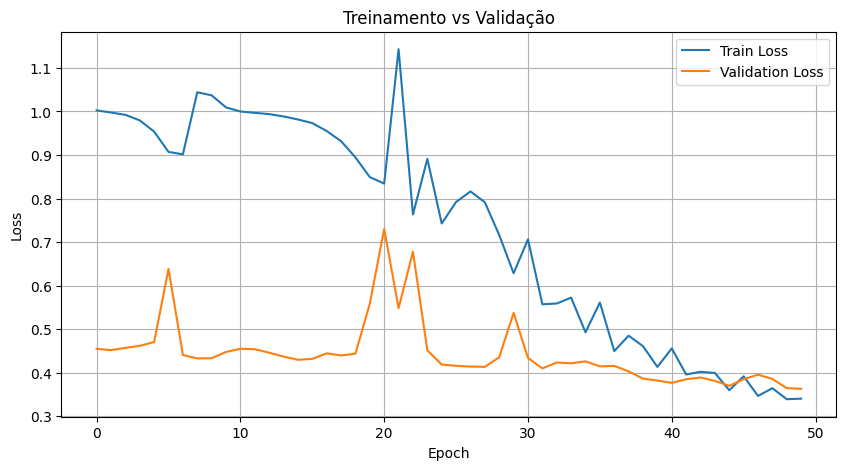

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Treinamento vs Validação")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
epoch_losses

[1.0023834705352783,
 0.9975007176399231,
 0.9921759963035583,
 0.9794169068336487,
 0.9536599516868591,
 0.9069955945014954,
 0.901451587677002,
 1.0440000295639038,
 1.0368914604187012,
 1.0092191696166992,
 0.9998825192451477,
 0.9967546463012695,
 0.9938305020332336,
 0.9884591698646545,
 0.9815142154693604,
 0.9731703996658325,
 0.954998791217804,
 0.9317396283149719,
 0.8944483995437622,
 0.8491358757019043,
 0.8343038558959961,
 1.1428487300872803,
 0.7633351683616638,
 0.8910331130027771,
 0.7426348328590393,
 0.7920612096786499,
 0.8163266777992249,
 0.7914127707481384,
 0.7160437703132629,
 0.6283903121948242,
 0.7063168287277222,
 0.557141900062561,
 0.5588886141777039,
 0.5724249482154846,
 0.4927460253238678,
 0.5611453056335449,
 0.4496116638183594,
 0.4849967658519745,
 0.46085891127586365,
 0.4133206903934479,
 0.4557498097419739,
 0.3959569036960602,
 0.4020424783229828,
 0.39941737055778503,
 0.35965242981910706,
 0.3917364180088043,
 0.34665369987487793,
 0.364401072

In [41]:
val_losses


[0.45480066537857056,
 0.4519058167934418,
 0.45690077543258667,
 0.46172386407852173,
 0.47033169865608215,
 0.6382491588592529,
 0.4405551254749298,
 0.4328441619873047,
 0.43317386507987976,
 0.4476534426212311,
 0.4549393057823181,
 0.45386314392089844,
 0.44593262672424316,
 0.43711742758750916,
 0.4296373426914215,
 0.4317239224910736,
 0.4444396495819092,
 0.4395863115787506,
 0.4437291920185089,
 0.5587131977081299,
 0.729956865310669,
 0.5482312440872192,
 0.677789032459259,
 0.45154979825019836,
 0.4187384247779846,
 0.4157869219779968,
 0.41404181718826294,
 0.41345444321632385,
 0.4354141652584076,
 0.5373923778533936,
 0.43395885825157166,
 0.40990230441093445,
 0.423387348651886,
 0.4215933680534363,
 0.4260067045688629,
 0.41453585028648376,
 0.41557660698890686,
 0.4030400514602661,
 0.3863929212093353,
 0.38197290897369385,
 0.37656721472740173,
 0.38496872782707214,
 0.38899463415145874,
 0.38111528754234314,
 0.36974307894706726,
 0.3851388096809387,
 0.3954315781593

In [42]:
# class InferenceHelper:
#     def __init__(self, vggt_model, dpt_head, device="cuda", dtype=torch.float32, img_size=(518, 518)):
#         """
#         Initializes the InferenceHelper.

#         Args:
#             vggt_model (torch.nn.Module): The trained VGGT backbone model.
#             dpt_head (torch.nn.Module): The trained DPTHead model.
#             device (str or torch.device): The device to run inference on.
#             dtype (torch.dtype): The data type for model inputs.
#             img_size (tuple): The target size for input images (height, width).
#         """
#         self.vggt_model = vggt_model.to(device).eval() # Ensure model is on device and in eval mode
#         self.dpt_head = dpt_head.to(device).eval()   # Ensure head is on device and in eval mode
#         self.device = device
#         self.dtype = dtype
#         self.img_size = img_size

#     def preprocess_image(self, image_path):
#         """
#         Loads and preprocesses a single GeoTIFF image for inference.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Preprocessed image tensor, or None if an error occurs.
#         """
#         try:
#             with rasterio.open(image_path) as src:
#                 image_data = src.read() # Shape (bands, height, width)

#                 # Convert to torch tensor and handle dtype
#                 image_tensor = torch.from_numpy(image_data).to(self.device, dtype=self.dtype)

#                 # Handle channel order/count if necessary (assuming model expects 3 channels)
#                 if image_tensor.shape[0] == 4:
#                     # Assuming RGBA, take RGB
#                     image_tensor = image_tensor[:3, :, :]
#                 elif image_tensor.shape[0] == 1:
#                      # Assuming grayscale, repeat channel
#                      image_tensor = image_tensor.repeat(3, 1, 1)
#                 elif image_tensor.shape[0] != 3:
#                     print(f"Warning: Input image has {image_tensor.shape[0]} bands. Expected 1, 3, or 4. Attempting to use first 3 if available.")
#                     if image_tensor.shape[0] >= 3:
#                          image_tensor = image_tensor[:3, :, :]
#                     else:
#                          print("Error: Cannot get 3 bands from input image. Skipping.")
#                          return None


#                 # Resize if necessary (assuming model expects IMG_SIZE)
#                 if image_tensor.shape[1:] != self.img_size:
#                      print(f"Resizing image from {image_tensor.shape[1:]} to {self.img_size}")
#                      # Add batch and channel dim for interpolation, then remove batch dim
#                      image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=self.img_size, mode='bilinear', align_corners=False).squeeze(0)


#                 # Add batch dimension for model input
#                 image_tensor = image_tensor.unsqueeze(0) # Shape [1, C, H, W]


#                 return image_tensor.to(self.device, dtype=self.dtype) # Ensure final dtype is correct

#         except Exception as e:
#             print(f"Error loading or preprocessing image {image_path}: {e}")
#             return None


#     def predict(self, image_path):
#         """
#         Performs inference on a single image.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Predicted height map tensor, or None if an error occurs.
#         """
#         input_tensor = self.preprocess_image(image_path)

#         if input_tensor is None:
#             return None

#         with torch.no_grad():
#             # Add sequence dimension [1, S=1, C, H, W]
#             images_seq = input_tensor.unsqueeze(1)
#             tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)
#             predicted_height_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx)

#             # Select the first sample from the batch and remove the sequence dimension
#             predicted_height = predicted_height_batch[:, 0].squeeze(0)

#         return predicted_height.squeeze(0) # Return shape [H, W]


#     def predict_and_visualize(self, image_path):
#         """
#         Performs inference and visualizes the predicted height map.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.
#         """
#         predicted_height_tensor = self.predict(image_path)

#         if predicted_height_tensor is not None:
#             # Move to CPU and convert to NumPy for visualization
#             predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

#             # Visualize the predicted height map
#             plt.figure(figsize=(6, 6))
#             plt.imshow(predicted_height_np, cmap='viridis')
#             plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
#             plt.colorbar(label='Predicted Height Value')
#             plt.axis('off')
#             plt.show()
#         else:
#             print(f"Could not generate prediction for {image_path}")

In [43]:
# # CHANGED: InferenceHelper with load_and_preprocess_geotiff

# class InferenceHelper:
#     def __init__(self, vggt_model, dpt_head, device="cuda", dtype=torch.float32, img_size=(518, 518)):
#         """
#         Inizializza l'InferenceHelper.

#         Args:
#             vggt_model (torch.nn.Module): Il modello backbone VGGT allenato.
#             dpt_head (torch.nn.Module): L'head DPT allenato.
#             device (str or torch.device): Il dispositivo su cui eseguire l'inferenza.
#             dtype (torch.dtype): Il tipo di dato per gli input del modello.
#             img_size (tuple): La dimensione target per le immagini di input (altezza, larghezza).
#         """
#         # Ensure models are on the correct device and in evaluation mode
#         self.vggt_model = vggt_model.to(device).eval()
#         self.dpt_head = dpt_head.to(device).eval()
#         self.device = device
#         self.dtype = dtype
#         self.img_size = img_size

#     def preprocess_image(self, image_path):
#         """
#         Loads and preprocesses a single GeoTIFF image for inference using
#         the project's load_and_preprocess_geotiff function.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Preprocessed image tensor [1, C, H, W], or None if an error occurs.
#         """
#         try:
#             # Use the existing utility function to load and preprocess
#             # Assumes load_and_preprocess_geotiff returns a tensor with shape [B, C, H, W]
#             # or similar, and handles normalization and initial resizing/cropping.
#             # We wrap image_path in a list as load_and_preprocess_geotiff expects a list.
#             image_tensor, _ = load_and_preprocess_geotiff([image_path], mode="crop", target_size=self.img_size)

#             if image_tensor is None:
#                  print(f"load_and_preprocess_geotiff returned None for {image_path}")
#                  return None

#             # load_and_preprocess_geotiff likely returns [B=1, C, H, W] for a single path input
#             # Ensure it's on the correct device and dtype, although the utility might handle this
#             image_tensor = image_tensor.to(self.device, dtype=self.dtype)

#             # Add batch dimension if not already present (utility might return [C, H, W]?)
#             # Based on RemoteSensingHeightDataset usage, it seems to return [B, C, H, W]
#             # If it returns [C, H, W], uncomment the line below:
#             # image_tensor = image_tensor.unsqueeze(0) # Shape [1, C, H, W]

#             # Check the final shape before returning
#             if image_tensor.ndim != 4 or image_tensor.shape[0] != 1 or image_tensor.shape[2:] != self.img_size:
#                  print(f"Warning: Unexpected tensor shape after loading/preprocessing: {image_tensor.shape}")
#                  # Attempt to fix common issues if possible, or raise error/return None
#                  if image_tensor.ndim == 3 and image_tensor.shape[1:] == self.img_size:
#                      print("Assuming shape is [C, H, W], adding batch dimension.")
#                      image_tensor = image_tensor.unsqueeze(0)
#                  elif image_tensor.ndim == 4 and image_tensor.shape[0] == 1:
#                       print(f"Assuming shape is [1, C, H, W], but spatial dims {image_tensor.shape[2:]} != {self.img_size}. Attempting resize.")
#                       image_tensor = F.interpolate(image_tensor, size=self.img_size, mode='bilinear', align_corners=False)
#                  else:
#                      print("Shape cannot be easily corrected. Returning None.")
#                      return None


#             return image_tensor

#         except Exception as e:
#             print(f"Error loading or preprocessing image {image_path} with utility function: {e}")
#             return None


#     def predict(self, image_path):
#         """
#         Performs inference on a single image.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.

#         Returns:
#             torch.Tensor: Predicted height map tensor [H, W], or None if an error occurs.
#         """
#         input_tensor = self.preprocess_image(image_path)

#         if input_tensor is None:
#             return None

#         with torch.no_grad():
#             # Add sequence dimension [1, S=1, C, H, W]
#             # input_tensor is already [1, C, H, W] from preprocess_image
#             images_seq = input_tensor.unsqueeze(1)

#             # Pass through VGGT aggregator
#             tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)

#             # Pass through DPT Head
#             predicted_output_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx) # predicted_output_batch shape is likely [B, S, output_dim, H', W']

#             # Select the first sample from the batch (since B=1)
#             # Select the first sequence element (since S=1)
#             # Select the first output channel (assuming height is the first output)
#             predicted_height_tensor = predicted_output_batch[:, 0, 0, :, :] # Shape [B, H', W'], where B=1

#             # Remove the batch dimension
#             predicted_height_tensor = predicted_height_tensor.squeeze(0) # Shape [H', W']

#             # Note: The output size (H', W') might be different from input size (H, W)
#             # depending on the DPTHead's architecture and the down_ratio.
#             # If your target output needs to be the same size as the input IMG_SIZE,
#             # you might need an F.interpolate step here if it's not handled by the head.
#             # Assuming the head outputs the correct size or close enough for now.


#         return predicted_height_tensor


#     def predict_and_visualize(self, image_path):
#         """
#         Performs inference and visualizes the predicted height map.

#         Args:
#             image_path (str): Path to the input GeoTIFF image.
#         """
#         predicted_height_tensor = self.predict(image_path)

#         if predicted_height_tensor is not None:
#             # Move to CPU and convert to NumPy for visualization
#             predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

#             # Visualize the predicted height map
#             plt.figure(figsize=(6, 6))
#             plt.imshow(predicted_height_np, cmap='viridis')
#             plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
#             plt.colorbar(label='Predicted Height Value')
#             plt.axis('off')
#             plt.show()
#         else:
#             print(f"Could not generate prediction for {os.path.basename(image_path)}")

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
# Supondo que load_and_preprocess_geotiff está definida em algum lugar
# from your_utils import load_and_preprocess_geotiff

class InferenceHelper:
    # 1. ADICIONE mds_mean e mds_std AO CONSTRUTOR
    def __init__(self, vggt_model, dpt_head, mds_mean, mds_std, device="cuda", dtype=torch.float32, img_size=(518, 518)):
        """
        Inicializa o InferenceHelper.

        Args:
            vggt_model (torch.nn.Module): O modelo backbone VGGT treinado.
            dpt_head (torch.nn.Module): O head DPT treinado.
            mds_mean (torch.Tensor): A média global para desnormalização.
            mds_std (torch.Tensor): O desvio padrão global para desnormalização.
            device (str or torch.device): O dispositivo para a inferência.
            dtype (torch.dtype): O tipo de dado para os inputs.
            img_size (tuple): O tamanho alvo para as imagens.
        """
        self.vggt_model = vggt_model.to(device).eval()
        self.dpt_head = dpt_head.to(device).eval()
        self.device = device
        self.dtype = dtype
        self.img_size = img_size

        # Armazena as estatísticas de desnormalização
        self.mds_mean = mds_mean.to(device)
        self.mds_std = mds_std.to(device)

    def preprocess_image(self, image_path):
        """
        Carrega e pré-processa uma única imagem GeoTIFF para inferência.
        """
        try:
            image_tensor, _ = load_and_preprocess_geotiff([image_path], mode="crop", target_size=self.img_size)

            if image_tensor is None:
                print(f"load_and_preprocess_geotiff retornou None para {image_path}")
                return None

            image_tensor = image_tensor.to(self.device, dtype=self.dtype)

            if image_tensor.ndim != 4 or image_tensor.shape[0] != 1:
                print(f"Warning: Shape inesperada após pré-processamento: {image_tensor.shape}")
                return None

            return image_tensor

        except Exception as e:
            print(f"Erro ao carregar ou pré-processar a imagem {image_path}: {e}")
            return None

    def predict(self, image_path):
        """
        Executa a inferência e desnormaliza o resultado.
        """
        input_tensor = self.preprocess_image(image_path)

        if input_tensor is None:
            return None

        with torch.no_grad():
            images_seq = input_tensor.unsqueeze(1)
            tokens_list, patch_start_idx = self.vggt_model.aggregator(images_seq)
            predicted_output_batch, _ = self.dpt_head(tokens_list, images_seq, patch_start_idx)

            # Predição normalizada [B, H', W'], com B=1
            predicted_normalized = predicted_output_batch[:, 0, 0, :, :]

            # APLIQUE A DESNORMALIZAÇÃO AQUI
            # Operação inversa: (pred * std) + mean
            predicted_denormalized = predicted_normalized * self.mds_std + self.mds_mean

            # Garante que a profundidade não seja negativa
            predicted_denormalized = torch.clamp(predicted_denormalized, min=0)

            # Remove a dimensão do batch para retornar [H', W']
            predicted_final = predicted_denormalized.squeeze(0)

        return predicted_final

    def predict_and_visualize(self, image_path):
        """
        Executa a inferência e visualiza o mapa de altura predito e desnormalizado.
        """
        predicted_height_tensor = self.predict(image_path)

        if predicted_height_tensor is not None:
            predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

            plt.figure(figsize=(6, 6))
            plt.imshow(predicted_height_np, cmap='viridis')
            plt.title(f"Predicted Height Map for {os.path.basename(image_path)}")
            # O colorbar agora mostrará os valores na escala correta (desnormalizados)
            plt.colorbar(label='Predicted Height Value (denormalized)')
            plt.axis('off')
            plt.show()
        else:
            print(f"Não foi possível gerar a predição para {os.path.basename(image_path)}")

In [45]:
# Example usage (assuming vggt_model and dpt_head are already trained and available)
# Replace 'path/to/your/test_image.tif' with the actual path to a test image

# Initialize the inference helper
# inference_helper = InferenceHelper(vggt_model, dpt_head, device=device, dtype=dtype, img_size=IMG_SIZE)

# Predict and visualize for a test image
# test_image_path = "/content/drive/MyDrive/Colab Notebooks/vggt/input_data/aa_test_input_data_all/tile_7770_7770.tif" # Replace with a valid path
# inference_helper.predict_and_visualize(test_image_path)

In [46]:
stats_file_path = 'mds_normalization_stats.txt' # Path where you saved the stats
loaded_mean = None
loaded_std = None

if os.path.exists(stats_file_path):
    try:
        with open(stats_file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('mean:'):
                    loaded_mean = float(line.split(':')[1])
                elif line.startswith('std:'):
                    loaded_std = float(line.split(':')[1])
        print(f"Loaded global normalization statistics: mean={loaded_mean}, std={loaded_std}")
    except IOError as e:
        print(f"Error loading normalization statistics: {e}")
    except ValueError:
        print(f"Error parsing normalization statistics file: {stats_file_path}")
else:
    raise FileNotFoundError(f"Normalization statistics file not found at {stats_file_path}. Cannot perform unnormalization.")

if loaded_mean is None or loaded_std is None:
    raise ValueError("Could not load both mean and standard deviation from the stats file.")

# Convert loaded values to tensors and move to device for unnormalization function if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_mds_mean_tensor = torch.tensor(loaded_mean).to(device)
global_mds_std_tensor = torch.tensor(loaded_std).to(device)

Loaded global normalization statistics: mean=7.258183479309082, std=13.633126258850098


In [47]:
# Define the paths for inference data
inference_input_path = "/content/drive/MyDrive/vggt/input_data/aa_inference_data_input"
inference_reference_path = "/content/drive/MyDrive/vggt/input_data/aa_inference_data_reference"

# List the inference input and reference files
inference_image_list = sorted([os.path.join(inference_input_path, f) for f in os.listdir(inference_input_path) if f.endswith(".tif") or f.endswith(".tiff")])
inference_reference_list = sorted([os.path.join(inference_reference_path, f) for f in os.listdir(inference_reference_path) if f.endswith(".tif") or f.endswith(".tiff")])

print(f"Found {len(inference_image_list)} inference input images.")
print(f"Found {len(inference_reference_list)} inference reference images.")

# Ensure the number of input and reference files match
if len(inference_image_list) != len(inference_reference_list):
    raise ValueError("The number of inference input and reference files do not match.")

Found 2 inference input images.
Found 2 inference reference images.


In [48]:
# # Initialize the inference helper
# # Assuming vggt_model and dpt_head are already trained and available in the environment
# inference_helper = InferenceHelper(vggt_model, dpt_head, device=device, dtype=dtype, img_size=IMG_SIZE)

# print("InferenceHelper instantiated.")

In [49]:
# Initialize the inference helper
# Assuming vggt_model and dpt_head are already trained and available in the environment
inference_helper = InferenceHelper(
    vggt_model=vggt_model,
    dpt_head=dpt_head,
    mds_mean=global_mds_mean_tensor,    # ✅ Passando a média carregada
    mds_std=global_mds_std_tensor,      # ✅ Passando o desvio padrão carregado
    device=device,
    dtype=dtype,
    img_size=IMG_SIZE
)

print("InferenceHelper instanciado com as estatísticas de desnormalização.")

InferenceHelper instanciado com as estatísticas de desnormalização.



Generating predictions and visualizations for inference data...

Processing tile_518_1036.tif...
Escalando imagem /content/drive/MyDrive/vggt/input_data/aa_inference_data_input/tile_518_1036.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


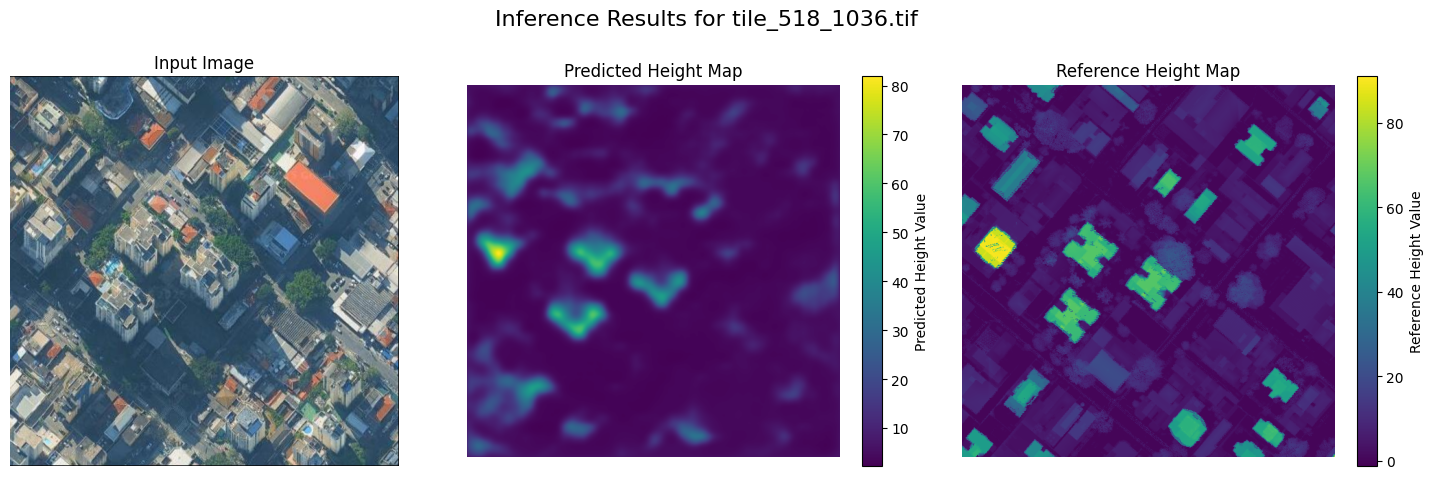


Processing tile_518_518.tif...
Escalando imagem /content/drive/MyDrive/vggt/input_data/aa_inference_data_input/tile_518_518.tif para o intervalo [0, 1].
Aplicando normalização Mean/Std em imagem de 3 canais.


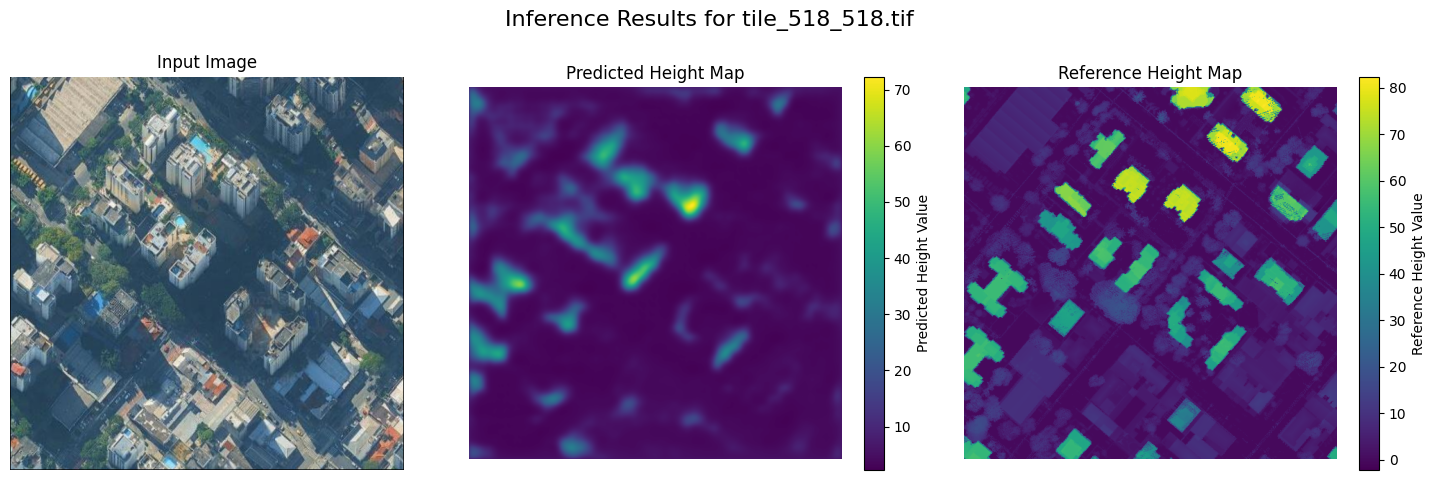


Inference and visualization complete.


In [50]:
# Iterate through the inference images, predict, and visualize
print("\nGenerating predictions and visualizations for inference data...")

# Visualize a limited number of inference results to avoid overwhelming output
max_visualizations = 10

for i, image_path in enumerate(inference_image_list):
    if i >= max_visualizations:
        print(f"Displayed {max_visualizations} inference results. Stopping visualization.")
        break

    reference_path = inference_reference_list[i] # Assuming sorted lists match

    print(f"\nProcessing {os.path.basename(image_path)}...")

    # Predict the height map
    predicted_height_tensor = inference_helper.predict(image_path)

    if predicted_height_tensor is not None:
        # Load the input image for visualization
        try:
            with rasterio.open(image_path) as src:
                input_image_data = src.read()
                input_image_np = input_image_data.transpose(1, 2, 0) # Transpose to (H, W, C)
                if input_image_np.shape[-1] == 4: # Handle RGBA
                    input_image_np = input_image_np[:, :, :3]
                elif input_image_np.shape[-1] == 1: # Handle grayscale
                     input_image_np = input_image_np.squeeze(-1)

            # Load the reference height map
            with rasterio.open(reference_path) as src:
                reference_height_data = src.read(1) # Read the single band
                reference_height_np = reference_height_data


            # Convert predicted height to NumPy
            predicted_height_np = predicted_height_tensor.detach().cpu().numpy()

            # Visualize Input, Predicted, and Reference
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"Inference Results for {os.path.basename(image_path)}", fontsize=16)

            # Input Image
            axes[0].imshow(input_image_np, cmap='gray' if input_image_np.ndim == 2 else None) # Use gray cmap for grayscale
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Predicted Height Map
            im1 = axes[1].imshow(predicted_height_np, cmap='viridis')
            axes[1].set_title("Predicted Height Map")
            axes[1].axis('off')
            fig.colorbar(im1, ax=axes[1], label='Predicted Height Value')

            # Reference Height Map
            im2 = axes[2].imshow(reference_height_np, cmap='viridis')
            axes[2].set_title("Reference Height Map")
            axes[2].axis('off')
            fig.colorbar(im2, ax=axes[2], label='Reference Height Value')


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show()

        except Exception as e:
            print(f"Error visualizing results for {os.path.basename(image_path)}: {e}")

    else:
        print(f"Skipping visualization for {os.path.basename(image_path)} due to prediction error.")

print("\nInference and visualization complete.")